### Import libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from Bio.SeqUtils.ProtParam import ProteinAnalysis

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, make_scorer, RocCurveDisplay
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

import xgboost as xgb
from xgboost import XGBClassifier

### 1. Load Datasets


In [2]:
negative = pd.read_csv(r"data\negative_protein_sequences.csv")
positive = pd.read_csv(r"data\positive_protein_sequences.csv")

### Analysing Datasets

Negative (sequences that do not interact)

In [3]:
negative.head()

,protein_sequences_1,protein_sequences_2
0,MSVEMDSSSFIQFDVPEYSSTVLSQLNELRLQGKLCDIIVHIQGQP...,MGDTFIRHIALLGFEKRFVPSQHYVYMFLVKWQDLSEKVVYRRFTE...
1,MPITRMRMRPWLEMQINSNQIPGLIWINKEEMIFQIPWKHAAKHGW...,MTMPVNGAHKDADLWSSHDKMLAQPLKDSDVEVYNIIKKESNRQRV...
2,MLCVRGARLKRELDATATVLANRQDESEQSRKRLIEQSREFKKNTP...,MRLTLLCCTWREERMGEEGSELPVCASCGQRIYDGQYLQALNADWH...
3,MDALESLLDEVALEGLDGLCLPALWSRLETRVPPFPLPLEPCTQEF...,MERLQKQPLTSPGSVSPSRDSSVPGSPSSIVAKMDNQVLGYKDLAA...
4,MALSRGLPRELAEAVAGGRVLVVGAGGIGCELLKNLVLTGFSHIDL...,MVVMNSLRVILQASPGKLLWRKFQIPRFMPARPCSLYTCTYKTRNR...


In [4]:
negative.shape

(36480, 2)

In [5]:
negative.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36480 entries, 0 to 36479
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   protein_sequences_1  36480 non-null  object
 1   protein_sequences_2  36480 non-null  object
dtypes: object(2)
memory usage: 570.1+ KB


Positive (sequences that do interact)

In [6]:
positive.head()

,protein_sequences_1,protein_sequences_2
0,MESSKKMDSPGALQTNPPLKLHTDRSAGTPVFVPEQGGYKEKFVKT...,MARPHPWWLCVLGTLVGLSATPAPKSCPERHYWAQGKLCCQMCEPG...
1,MVMSSYMVNSKYVDPKFPPCEEYLQGGYLGEQGADYYGGGAQGADF...,MAENVVEPGPPSAKRPKLSSPALSASASDGTDFGSLFDLEHDLPDE...
2,MNRHLWKSQLCEMVQPSGGPAADQDVLGEESPLGKPAMLHLPSEQG...,MEGGRRARVVIESKRNFFLGAFPTPFPAEHVELGRLGDSETAMVPG...
3,MAPPSTREPRVLSATSATKSDGEMVLPGFPDADSFVKFALGSVVAV...,MLFYSFFKSLVGKDVVVELKNDLSICGTLHSVDQYLNIKLTDISVT...
4,MQSGPRPPLPAPGLALALTLTMLARLASAASFFGENHLEVPVATAL...,MQTIKCVVVGDGAVGKTCLLISYTTNKFPSEYVPTVFDNYAVTVMI...


In [7]:
positive.shape

(36630, 2)

In [8]:
positive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36630 entries, 0 to 36629
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   protein_sequences_1  36630 non-null  object
 1   protein_sequences_2  36630 non-null  object
dtypes: object(2)
memory usage: 572.5+ KB


### 1.1 Pre-Processing

In [9]:
# Create the target column for binary classification.
# Positive interactions are labeled as 1, negative interactions as 0.

positive["target"] = 1
negative["target"] = 0

In [10]:
# Combine the two datasets of non-interacting and interacting sequences into a single DataFrame.
proteins = pd.concat([positive, negative], ignore_index=True)

# Visualise new DataFrame of combined proteins (positive interactions first and negative interactions last, annotated with target 1 and 0 respectively).
proteins.head()

,protein_sequences_1,protein_sequences_2,target
0,MESSKKMDSPGALQTNPPLKLHTDRSAGTPVFVPEQGGYKEKFVKT...,MARPHPWWLCVLGTLVGLSATPAPKSCPERHYWAQGKLCCQMCEPG...,1
1,MVMSSYMVNSKYVDPKFPPCEEYLQGGYLGEQGADYYGGGAQGADF...,MAENVVEPGPPSAKRPKLSSPALSASASDGTDFGSLFDLEHDLPDE...,1
2,MNRHLWKSQLCEMVQPSGGPAADQDVLGEESPLGKPAMLHLPSEQG...,MEGGRRARVVIESKRNFFLGAFPTPFPAEHVELGRLGDSETAMVPG...,1
3,MAPPSTREPRVLSATSATKSDGEMVLPGFPDADSFVKFALGSVVAV...,MLFYSFFKSLVGKDVVVELKNDLSICGTLHSVDQYLNIKLTDISVT...,1
4,MQSGPRPPLPAPGLALALTLTMLARLASAASFFGENHLEVPVATAL...,MQTIKCVVVGDGAVGKTCLLISYTTNKFPSEYVPTVFDNYAVTVMI...,1


### 2. Cleaning data

remove sequences with non-standard amino acid letters to prevent errors during BioPython analysis, and to preserve biological relevance

In [11]:

# Define standard amino acids
amino_acids = set("ACDEFGHIKLMNPQRSTVWY")

# Make function to check if sequence contains only the standard amino acids
def standard_seq(seq):
    return set(seq).issubset(amino_acids)

# Only keep the rows where BOTH of the sequences are standard
mask = proteins["protein_sequences_1"].apply(standard_seq) & proteins["protein_sequences_2"].apply(standard_seq)
proteins = proteins[mask].reset_index(drop=True)


### 3. Feature extraction from amino acid sequences

Sequence length

In [12]:
# Amino acid sequence length calculation and addition as new feature to DataFrame.

proteins["Seq_1_length"] = proteins["protein_sequences_1"].str.len()
proteins["Seq_2_length"] = proteins["protein_sequences_2"].str.len()

Sequence similarity

In [13]:
# Amino acid pairwise sequence similarity calculation and addition as new feature to DataFrame.

proteins["Length_difference"] = abs(proteins["Seq_1_length"] - proteins["Seq_2_length"])
proteins["Length_sum"] = proteins["Seq_1_length"] + proteins["Seq_2_length"]

Proportion of each amino acid in sequence

In [14]:
# Making a function to count the proportion if amino acids in a sequence.

amino_acids = "ACDEFGHIKLMNPQRSTVWY" # defining what amino acids to look for.

# Creating the function that will calculate the frequency of each amino acid in a sequence that you give it.
def amino_acid_proportion(seq):
    length = len(seq)
    return [seq.count(a) / length for a in amino_acids]

In [15]:
# Using the amino_acid_proportion function to get proportion of each amino acid in protein sequences 1. This creates a new DataFrame.
proportion1 = proteins["protein_sequences_1"].apply(amino_acid_proportion).apply(pd.Series)
proportion1.columns = [f"Seq_1_{a}" for a in amino_acids]

# Using the amino_acid_proportion function to get proportion of each amino acid in protein sequences 2. This creates a second new DataFrame.
proportion2 = proteins["protein_sequences_2"].apply(amino_acid_proportion).apply(pd.Series)
proportion2.columns = [f"Seq_2_{a}" for a in amino_acids]

# Combine the Dataframes with amino acid proportions back into the main proteins DataFrame.
proteins = pd.concat([proteins, proportion1, proportion2], axis=1)
proteins.head()
# This gives 40 new columns (20 for each sequence), with the proportion of each of the 20 amino acids in each sequence (1 and 2).

,protein_sequences_1,protein_sequences_2,target,Seq_1_length,Seq_2_length,Length_difference,Length_sum,Seq_1_A,Seq_1_C,Seq_1_D,...,Seq_2_M,Seq_2_N,Seq_2_P,Seq_2_Q,Seq_2_R,Seq_2_S,Seq_2_T,Seq_2_V,Seq_2_W,Seq_2_Y
0,MESSKKMDSPGALQTNPPLKLHTDRSAGTPVFVPEQGGYKEKFVKT...,MARPHPWWLCVLGTLVGLSATPAPKSCPERHYWAQGKLCCQMCEPG...,1,568,260,308,828,0.047535,0.049296,0.052817,...,0.019231,0.023077,0.107692,0.046154,0.076923,0.080769,0.057692,0.034615,0.019231,0.019231
1,MVMSSYMVNSKYVDPKFPPCEEYLQGGYLGEQGADYYGGGAQGADF...,MAENVVEPGPPSAKRPKLSSPALSASASDGTDFGSLFDLEHDLPDE...,1,255,2414,2159,2669,0.070588,0.015686,0.031373,...,0.048882,0.050953,0.117647,0.115162,0.041425,0.080779,0.050953,0.043911,0.004971,0.018641
2,MNRHLWKSQLCEMVQPSGGPAADQDVLGEESPLGKPAMLHLPSEQG...,MEGGRRARVVIESKRNFFLGAFPTPFPAEHVELGRLGDSETAMVPG...,1,419,538,119,957,0.100239,0.026253,0.035800,...,0.031599,0.039033,0.046468,0.048327,0.057621,0.072491,0.042751,0.035316,0.001859,0.035316
3,MAPPSTREPRVLSATSATKSDGEMVLPGFPDADSFVKFALGSVVAV...,MLFYSFFKSLVGKDVVVELKNDLSICGTLHSVDQYLNIKLTDISVT...,1,885,95,790,980,0.075706,0.015819,0.058757,...,0.021053,0.031579,0.031579,0.073684,0.031579,0.073684,0.042105,0.115789,0.000000,0.042105
4,MQSGPRPPLPAPGLALALTLTMLARLASAASFFGENHLEVPVATAL...,MQTIKCVVVGDGAVGKTCLLISYTTNKFPSEYVPTVFDNYAVTVMI...,1,2322,191,2131,2513,0.096469,0.005168,0.047373,...,0.010471,0.026178,0.078534,0.031414,0.031414,0.052356,0.083770,0.099476,0.005236,0.036649


Physiochemical protein property extraction (using BioPython)

In [16]:
# Use the ProteinAnalysis module from Biopython to calculate additional features for each protein sequence.

# Set up a function to extract features using ProteinAnalysis.
def extract_protein_features(seq):

    analysis = ProteinAnalysis(seq)
    helix, turn, sheet = analysis.secondary_structure_fraction()

    return {
        "mw": analysis.molecular_weight(), # Molecular weight (kDa).
        "aromaticity": analysis.aromaticity(), # Aromaticity, measured as the fraction of aromatic amino acids (F, W, Y), which affects the stability of the protein and its interactions.
        "instability_index": analysis.instability_index(), # Stability. Values over 40 suggest the protein is likely unstable. Uses the Guruprasad et al. (1990) method.
        "isoelectric_point": analysis.isoelectric_point(), # pI, the pH at which the protein has no net charge. Important for solubility and interactions.
        "flexibility_mean": np.mean(analysis.flexibility()), # Flexibility analysis returns a Python list, so we make it into a NumPy array and take the mean so we get one column of the average flexibility across the protein sequence.
        "helix": helix, # Proportion of amino acids predicted to be in alpha-helices.
        "turn": turn,  # Proportion of amino acids predicted to be in turns.
        "sheet": sheet # Proportion of amino acids predicted to be in beta-sheets. 
    }


In [17]:
# Apply the extract_protein_features function to protein sequence 1.
features1 = proteins["protein_sequences_1"].apply(extract_protein_features).apply(pd.Series)
features1 = features1.add_prefix("Seq_1_")

# Apply the extract_protein_features function to protein sequence 2.
features2 = proteins["protein_sequences_2"].apply(extract_protein_features).apply(pd.Series)
features2 = features2.add_prefix("Seq_2_")

# Combine the two new features data frames with the original proteins DataFrame.
proteins_full = pd.concat([proteins, features1, features2], axis=1)

# Look at the combined DataFrame to see all the features.
proteins_full.head()




,protein_sequences_1,protein_sequences_2,target,Seq_1_length,Seq_2_length,Length_difference,Length_sum,Seq_1_A,Seq_1_C,Seq_1_D,...,Seq_1_turn,Seq_1_sheet,Seq_2_mw,Seq_2_aromaticity,Seq_2_instability_index,Seq_2_isoelectric_point,Seq_2_flexibility_mean,Seq_2_helix,Seq_2_turn,Seq_2_sheet
0,MESSKKMDSPGALQTNPPLKLHTDRSAGTPVFVPEQGGYKEKFVKT...,MARPHPWWLCVLGTLVGLSATPAPKSCPERHYWAQGKLCCQMCEPG...,1,568,260,308,828,0.047535,0.049296,0.052817,...,0.265845,0.308099,29156.0952,0.069231,65.014615,8.034840,0.997092,0.269231,0.292308,0.273077
1,MVMSSYMVNSKYVDPKFPPCEEYLQGGYLGEQGADYYGGGAQGADF...,MAENVVEPGPPSAKRPKLSSPALSASASDGTDFGSLFDLEHDLPDE...,1,255,2414,2159,2669,0.070588,0.015686,0.031373,...,0.388235,0.243137,264158.0033,0.041839,67.039022,8.805237,1.009177,0.271748,0.354184,0.241094
2,MNRHLWKSQLCEMVQPSGGPAADQDVLGEESPLGKPAMLHLPSEQG...,MEGGRRARVVIESKRNFFLGAFPTPFPAEHVELGRLGDSETAMVPG...,1,419,538,119,957,0.100239,0.026253,0.035800,...,0.178998,0.229117,61834.9168,0.083643,46.614870,5.157991,1.005415,0.343866,0.282528,0.340149
3,MAPPSTREPRVLSATSATKSDGEMVLPGFPDADSFVKFALGSVVAV...,MLFYSFFKSLVGKDVVVELKNDLSICGTLHSVDQYLNIKLTDISVT...,1,885,95,790,980,0.075706,0.015819,0.058757,...,0.273446,0.315254,10834.3930,0.084211,21.182211,6.047464,0.997905,0.315789,0.252632,0.410526
4,MQSGPRPPLPAPGLALALTLTMLARLASAASFFGENHLEVPVATAL...,MQTIKCVVVGDGAVGKTCLLISYTTNKFPSEYVPTVFDNYAVTVMI...,1,2322,191,2131,2513,0.096469,0.005168,0.047373,...,0.303618,0.355297,21258.3571,0.083770,44.060733,6.156766,1.003058,0.324607,0.261780,0.408377


In [76]:
proteins_full.describe()

,target,Seq_1_length,Seq_2_length,Length_difference,Length_sum,Seq_1_A,Seq_1_C,Seq_1_D,Seq_1_E,Seq_1_F,...,Seq_1_turn,Seq_1_sheet,Seq_2_mw,Seq_2_aromaticity,Seq_2_instability_index,Seq_2_isoelectric_point,Seq_2_flexibility_mean,Seq_2_helix,Seq_2_turn,Seq_2_sheet
count,72945.000000,72945.000000,72945.000000,72945.000000,72945.000000,72945.000000,72945.000000,72945.000000,72945.000000,72945.000000,...,72945.000000,72945.000000,7.294500e+04,72945.000000,72945.000000,72945.000000,72945.000000,72945.000000,72945.000000,72945.000000
mean,0.502036,622.840620,583.631681,468.367236,1206.472301,0.072769,0.020117,0.049816,0.073282,0.033154,...,0.305035,0.308867,6.507394e+04,0.075548,47.555787,6.863575,1.003749,0.327704,0.288683,0.329739
std,0.499999,697.561605,653.071157,800.274360,983.827064,0.027976,0.016126,0.017476,0.027486,0.013916,...,0.053354,0.055404,7.255344e+04,0.024038,12.912596,1.642898,0.006733,0.048919,0.049354,0.050126
min,0.000000,24.000000,24.000000,0.000000,83.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.040000,0.050505,2.687231e+03,0.000000,-19.693671,4.050028,0.969622,0.034826,0.028571,0.044444
25%,0.000000,305.000000,276.000000,121.000000,702.000000,0.054622,0.010582,0.039333,0.055556,0.023560,...,0.268786,0.274566,3.060760e+04,0.059701,39.476279,5.570244,0.999474,0.297983,0.257004,0.304348
50%,1.000000,466.000000,432.000000,278.000000,987.000000,0.067797,0.016990,0.049679,0.070640,0.032051,...,0.299465,0.311601,4.829089e+04,0.076000,46.656924,6.331659,1.002724,0.327536,0.281776,0.336957
75%,1.000000,743.000000,709.000000,564.000000,1439.000000,0.085299,0.025641,0.059172,0.086036,0.041860,...,0.337123,0.346521,7.894704e+04,0.091039,54.525836,8.330363,1.007501,0.354651,0.313364,0.361290
max,1.000000,33423.000000,33423.000000,33274.000000,41391.000000,0.307229,0.368159,0.185714,0.382353,0.129707,...,0.606362,0.677419,3.713628e+06,0.227723,167.656863,11.999968,1.051101,0.632743,0.612245,0.571429


proteins_full is the final DataFrame with all features included.

### 4.1 Defining  X and y variables 


In [77]:
X = proteins_full.drop(columns=["protein_sequences_1", "protein_sequences_2", "target"]) # X is the features extracted from the protein sequences.
y = proteins_full["target"] # y is the target column (if the proteins interact (1) or do not interact (0)).

### 4.2 Exploring amino acid features

<Figure size 1500x1500 with 0 Axes>

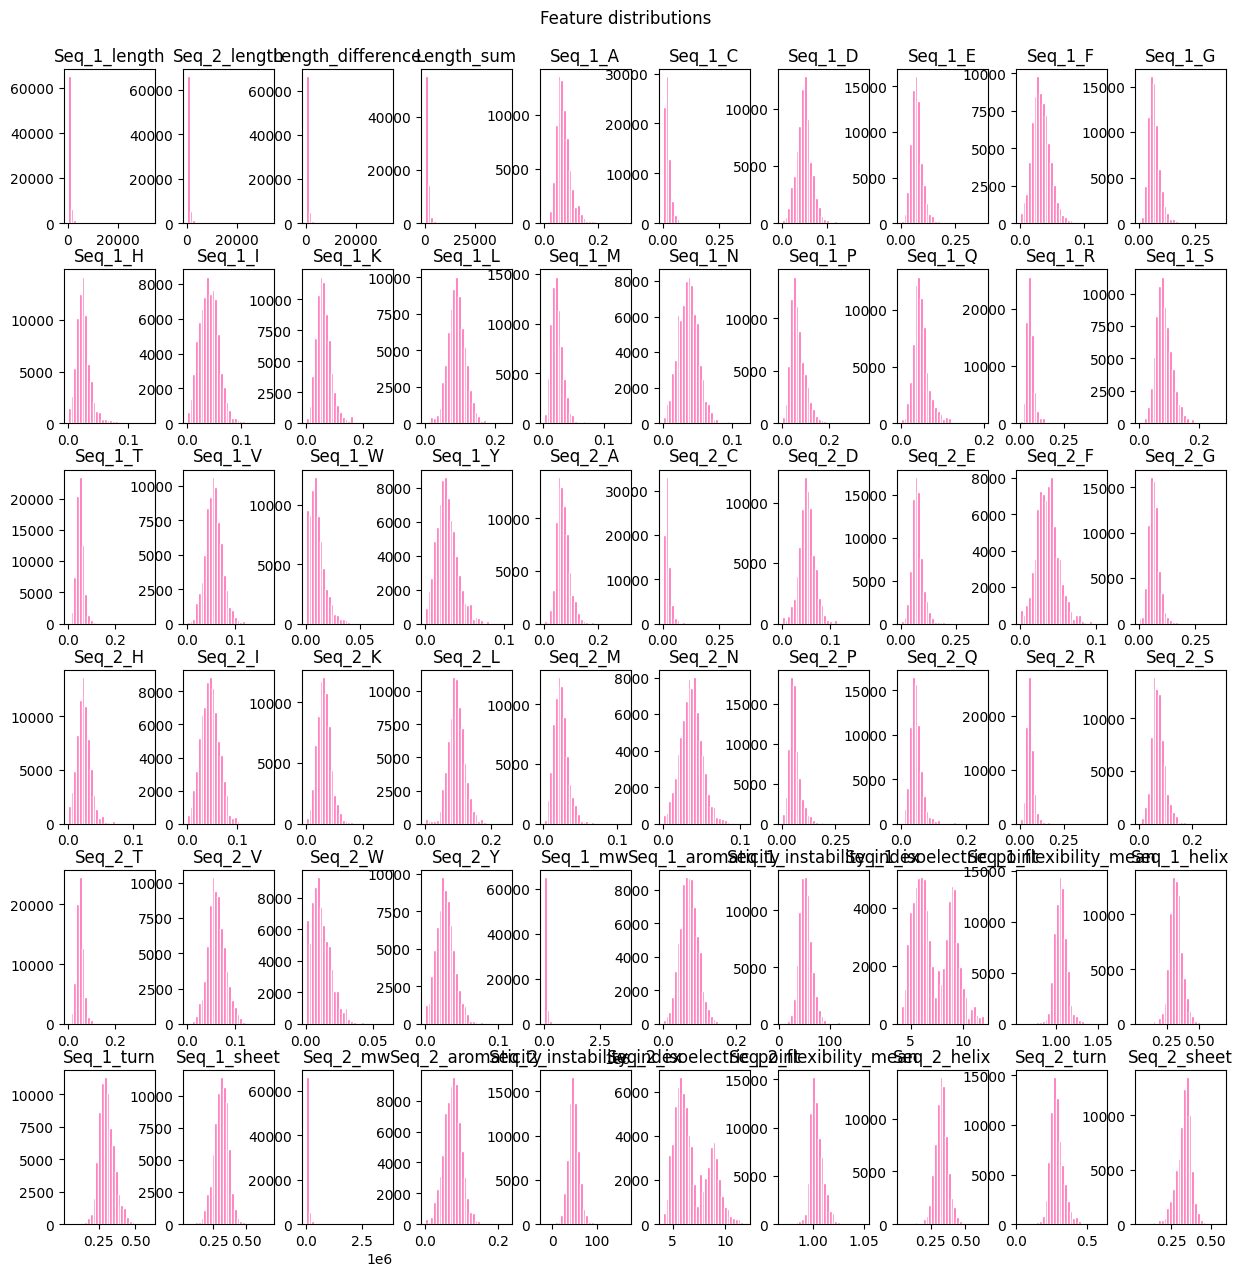

In [20]:
# Histograms for all X features

plt.figure(figsize=(15, 15))
X.hist(bins=30, figsize=(15, 15), layout=(6,10), color="hotpink", edgecolor="white", grid=False)
plt.suptitle("Feature distributions", y=0.92)
plt.show()


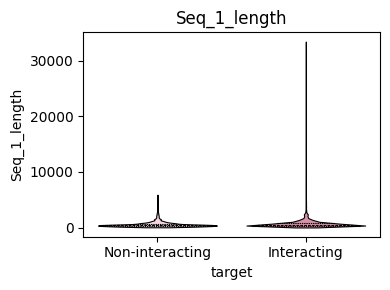

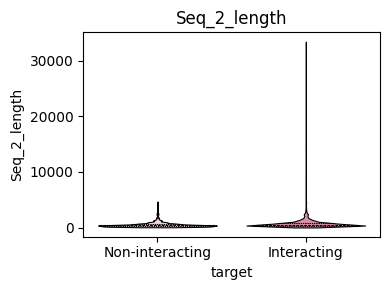

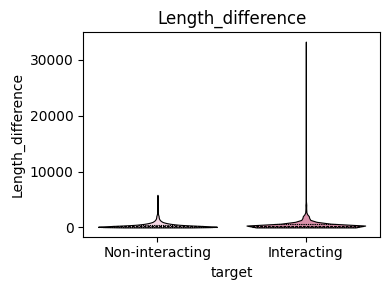

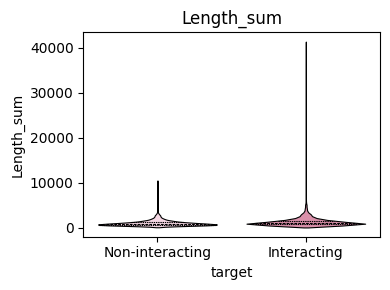

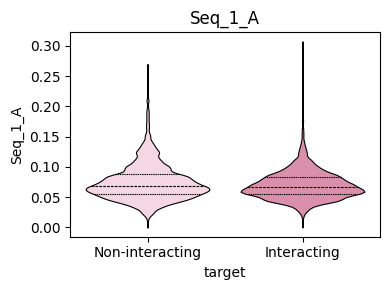

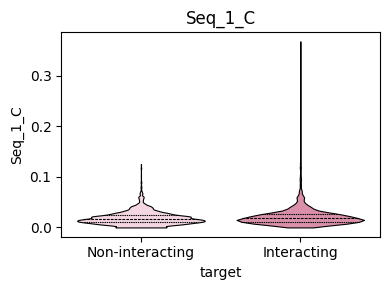

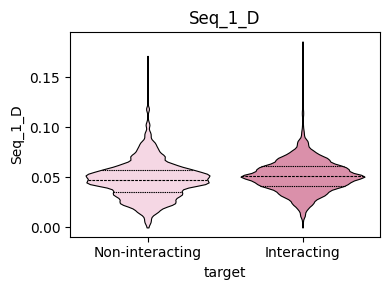

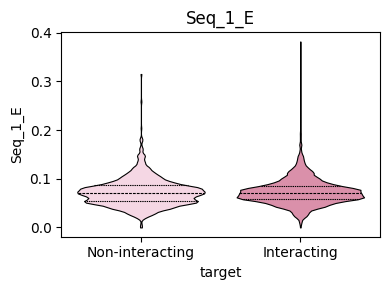

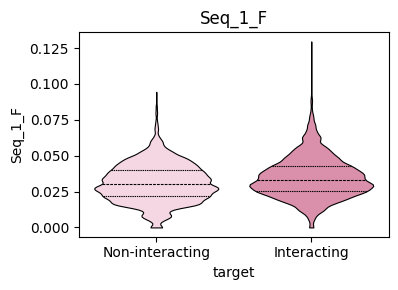

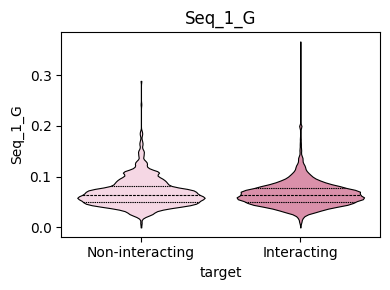

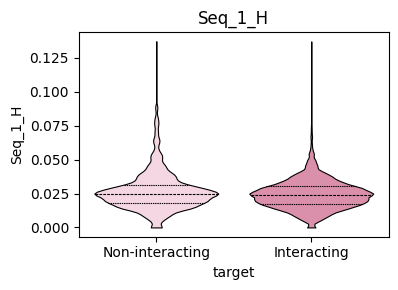

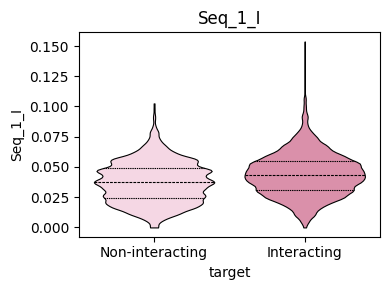

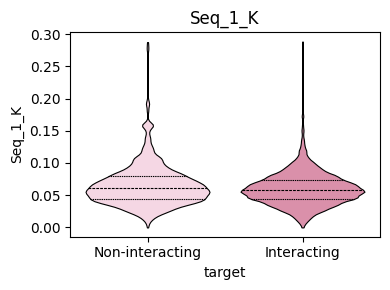

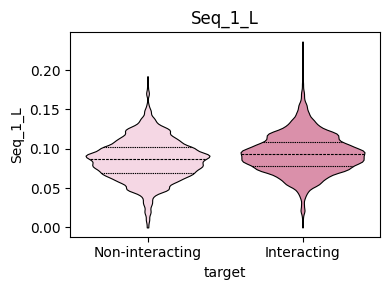

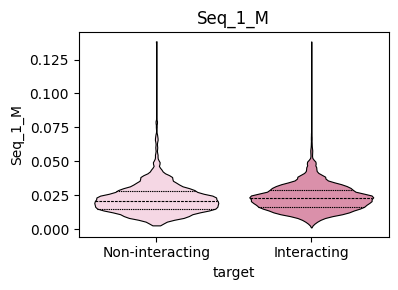

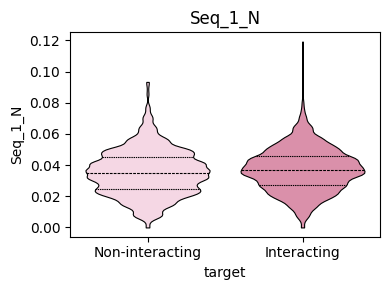

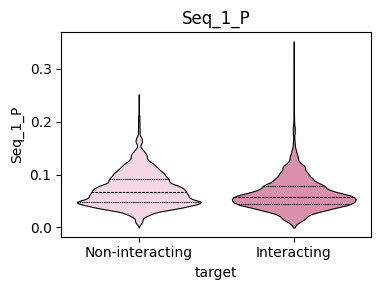

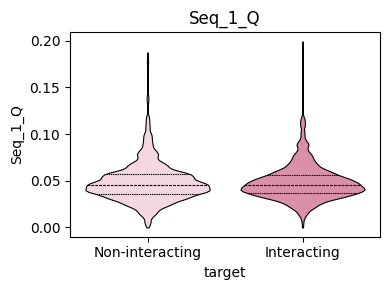

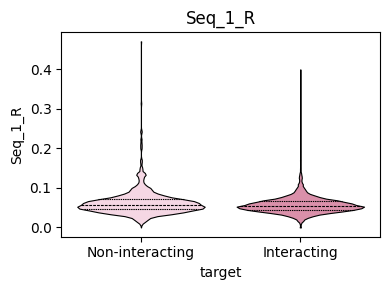

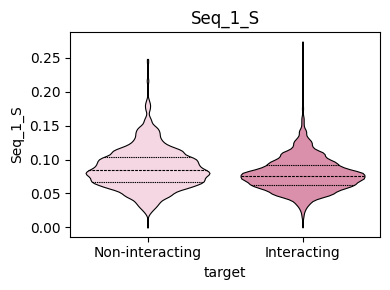

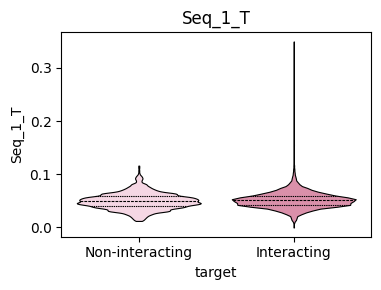

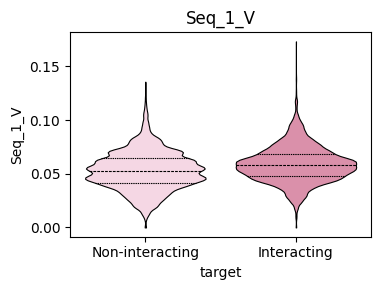

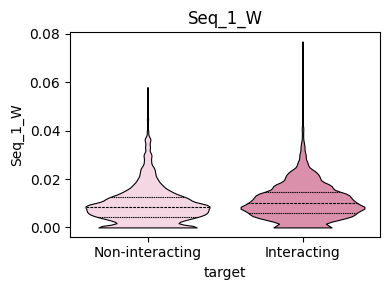

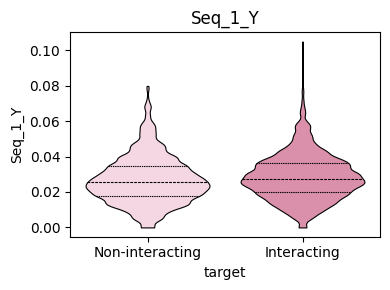

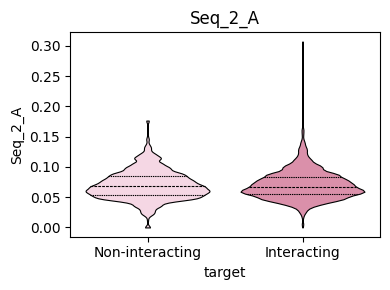

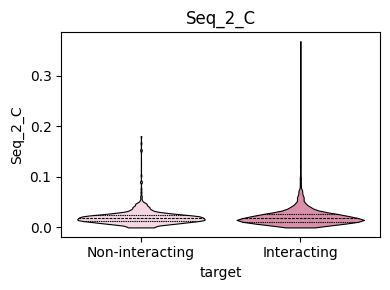

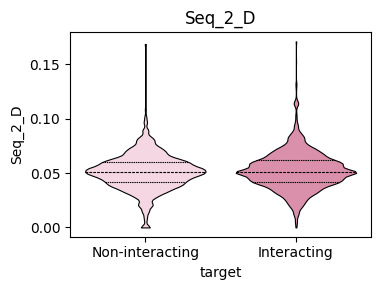

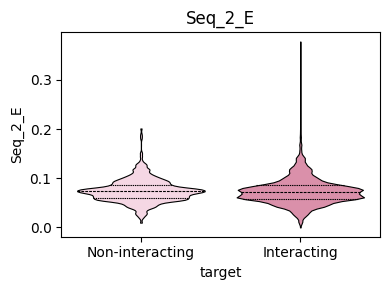

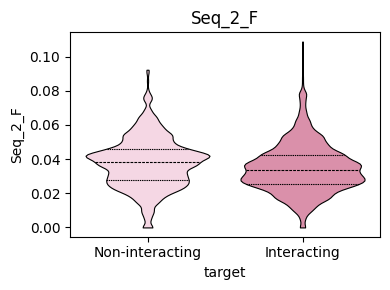

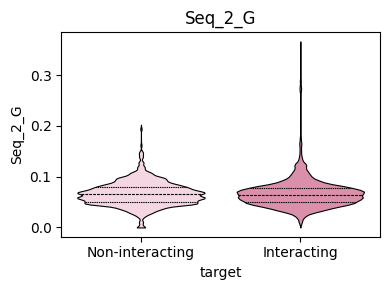

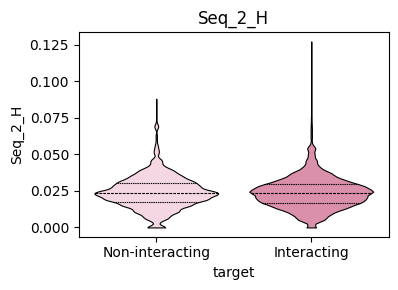

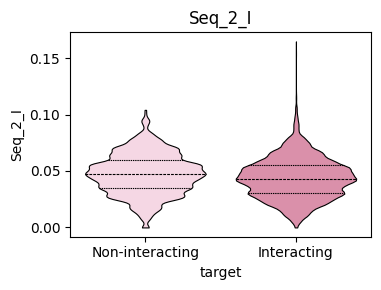

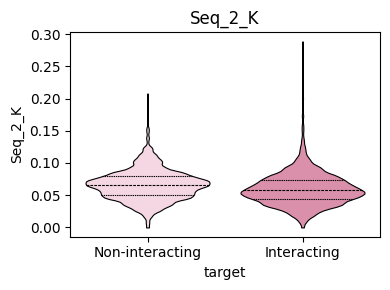

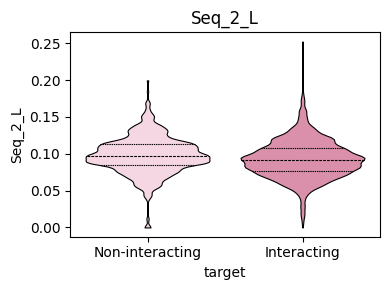

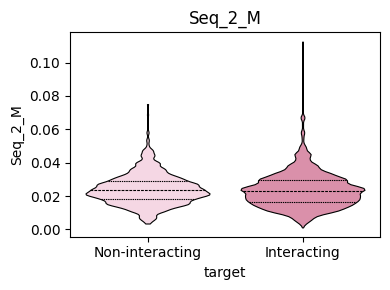

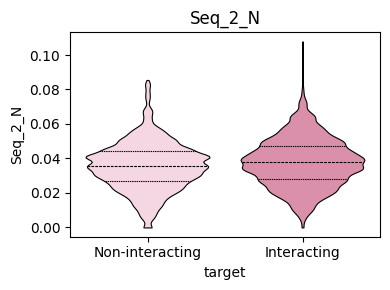

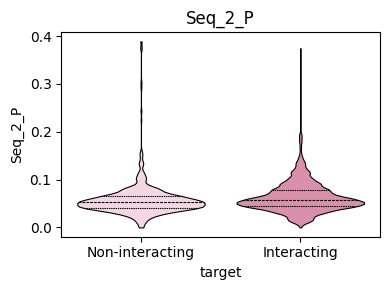

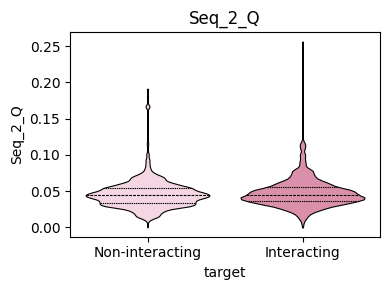

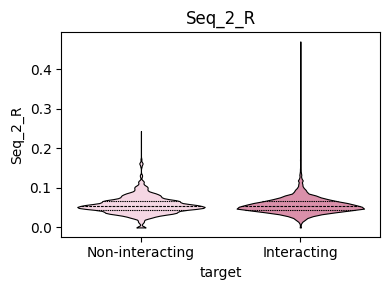

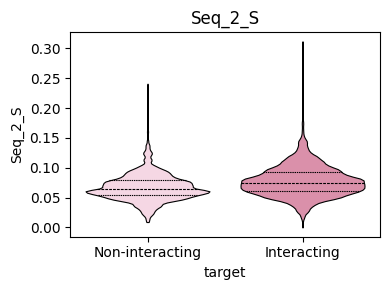

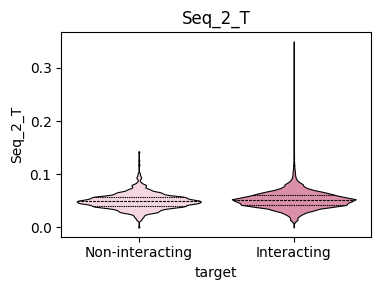

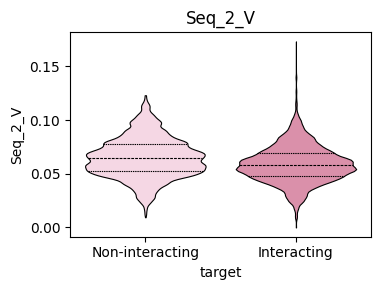

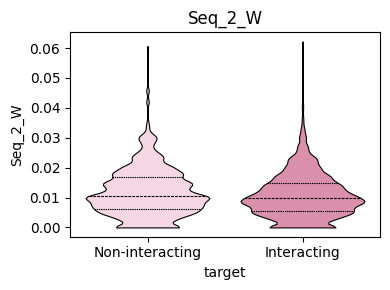

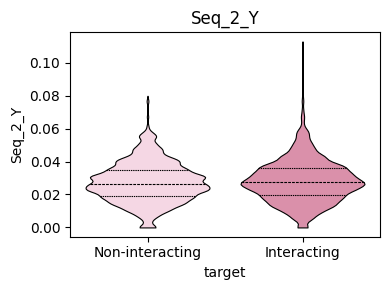

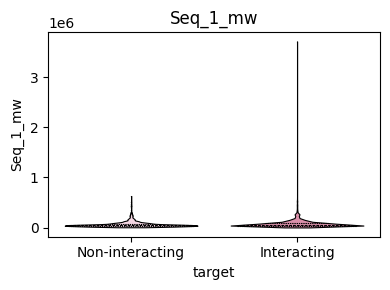

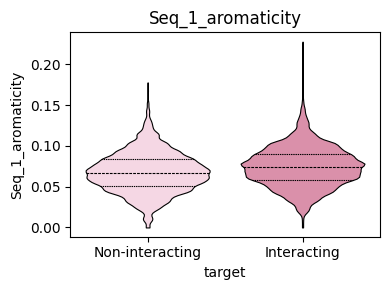

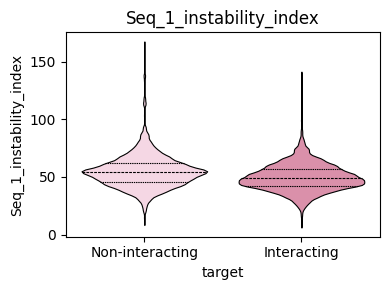

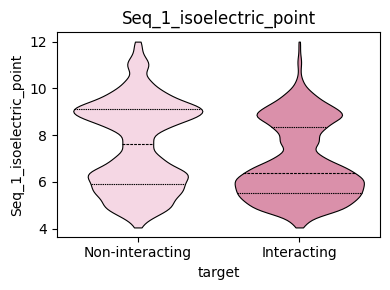

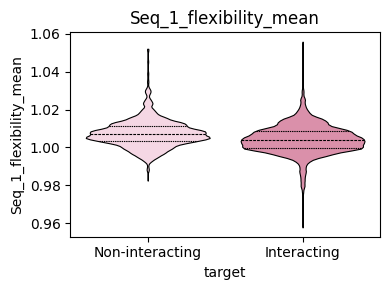

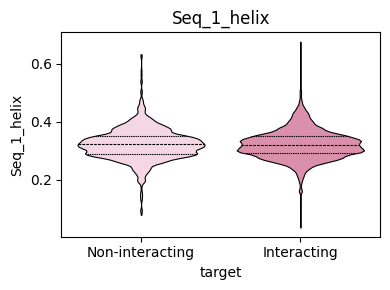

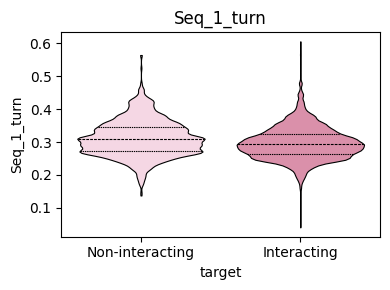

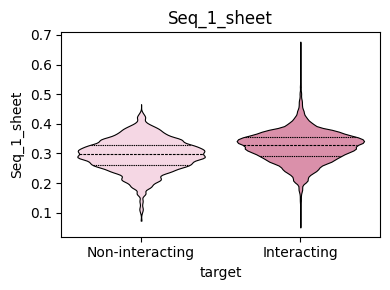

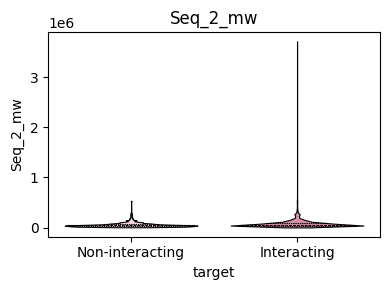

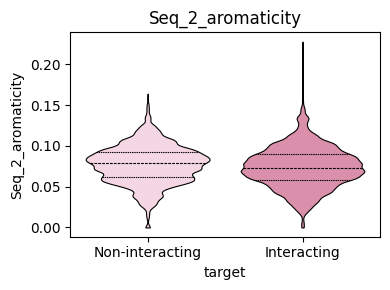

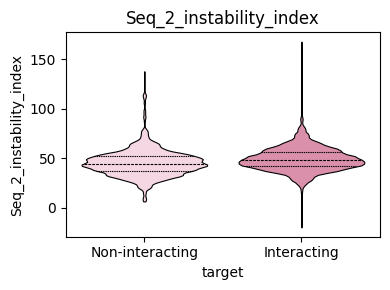

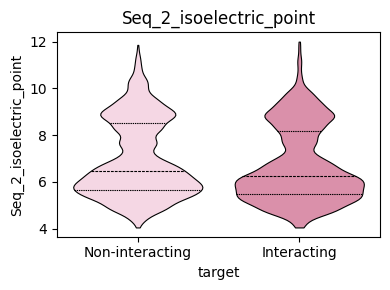

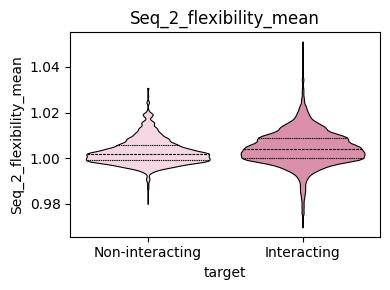

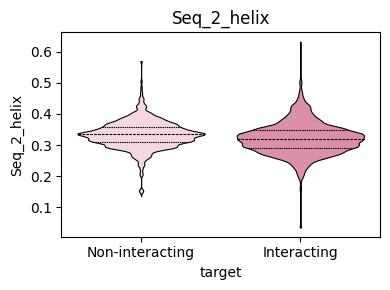

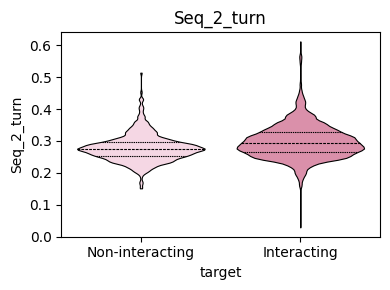

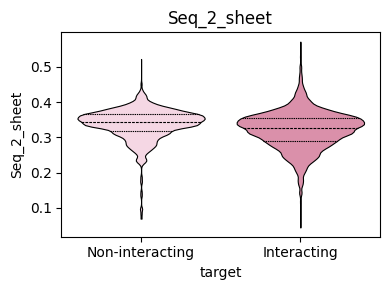

In [21]:
# Combine X and y to explore relationsihps between each feature in non-interacting and interacting proteins
plot_protein_df = X.copy()
plot_protein_df["target"] = y

palette = {0: "#FAD2E3", 1: "#E684A7"}

for column in X.columns:
    plt.figure(figsize=(4, 3))
    
    sns.violinplot(
        x="target",
        y=column,
        data=plot_protein_df,
        inner="quartile",
        cut = 0,
        hue="target",
        palette=palette,
        linewidth=0.8,
        linecolor="black",
        legend=False,
    )

    plt.xlabel
    plt.ylabel(column)
    plt.title(f"{column}")
    
    plt.xticks(
        ticks=[0, 1],
        labels=["Non-interacting", "Interacting"]
    )

    plt.tight_layout()
    plt.show()

### 4.3 Splitting data

Split into testing and training datasets

In [78]:
X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(X , y, test_size=0.25, random_state=42, stratify=y)

### 5. Scaling the test and train X variables

In [79]:
# Adding a scaler to the X variables due to differing orders of magnitude which may affect model performance by making some features more important than others.
# Scaling after slpitting to avoid data leakage.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_unscaled)
X_test = scaler.transform(X_test_unscaled)

#this had a marginal improvement on the RanomForest model accuracy, increasing it from 0.7450 to 0.7467.



////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# 6. Machine Learning Model 1 - Random Forest Model

////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

### 6.1 Training the base RandomForest Model

In [24]:
RandomForestModel = RandomForestClassifier(
    random_state=42, # select seed for reproducibility
    n_jobs=-1  # use all CPU cores
)

# Fit the model
RandomForestModel.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

Make predictions

In [25]:
y_pred = RandomForestModel.predict(X_test)

Check performance 

Accuracy:  0.974666886000987
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      9081
           1       0.99      0.96      0.97      9156

    accuracy                           0.97     18237
   macro avg       0.97      0.97      0.97     18237
weighted avg       0.97      0.97      0.97     18237



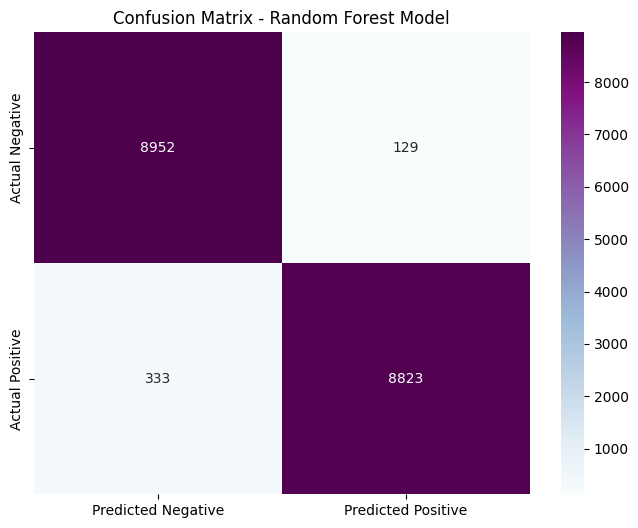

In [26]:
# Accuracy
print("Accuracy: ", accuracy_score(y_test, y_pred))

# Detailed classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="BuPu", 
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.title("Confusion Matrix - Random Forest Model")
plt.show()

### 6.2 Hyperparameter tuning - Random Forest Model

In [27]:
# Hyperparameter tuning for the Random Forest model.

# Defining the output from the parameter tuning.
scoring = {"accuracy": make_scorer(accuracy_score)} # Specifying the accuracy score from sklearn.metrics to measure model accuracy.
cross_val_score_param = StratifiedKFold(n_splits=5, shuffle = True, random_state=1) # Specifying the 2 fold stratified cross validation from sklearn.mode_selection that I want to use for the parameter tuning.

# Random Forest model - defining grid for parameters to be tuned.
RandomForestModel_base = RandomForestClassifier(random_state=42, n_jobs=-1, verbose= 2)
Parameter_grid =  {
    "max_depth": [None, 10, 20, 30],
    "max_features": ["sqrt", "log2", 0.3],
    "min_samples_leaf": [1, 5, 15],
    "n_estimators": [100, 250, 500]
}

# Using HalvingGrindSearchCV to speed up parameter tuning time.
RandomForestModel_tuned = HalvingGridSearchCV(
    estimator=RandomForestModel_base,
    param_grid=Parameter_grid,
    scoring="accuracy",
    refit="accuracy",
    cv=cross_val_score_param,
    n_jobs=-1,
    verbose=3
)

RandomForestModel_tuned.fit(X_train, y_train) # This will train and fit the data to the models in the grid.
Best_RandomForest_model = RandomForestModel_tuned.best_estimator_ # Best_RanodmForest_model will be the best of the tuned RF models from the grid.

print("Best parameters:", RandomForestModel_tuned.best_params_)
print("Best cross validation accuracy:", RandomForestModel_tuned.best_score_)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 675
max_resources_: 54708
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 108
n_resources: 675
Fitting 5 folds for each of 108 candidates, totalling 540 fits


KeyboardInterrupt: 

Extracting detailed CV scores for tuned Random Forest model

In [ ]:
# Extract score results from cross validation for best model.
best_RandomForestModel_df = pd.DataFrame(RandomForestModel_tuned.cv_results_) # Using the grid, output every test and train score for each fold using every parameter combination. 
best_cv_scores_index = RandomForestModel_tuned.best_index_ # Find the index of the best model (best parameters).

#Getting the mean and std of the cv scores for the best model.
mean_score_best_RF_model = RandomForestModel_tuned.cv_results_["mean_test_score"][best_cv_scores_index] # Find the mean test score of every fold for the best model.
std_score_best_RF_model  = RandomForestModel_tuned.cv_results_["std_test_score"][best_cv_scores_index] # Finding the std of the test scores for every fold of the best model.

# Find the cv score for each of the 5 folds for the best model.
fold_columns = [f"split{i}_test_score" for i in range(5)] # Get the column name of each fold test score. (5 folds range).
per_fold_best = best_RandomForestModel_df.loc[best_cv_scores_index, fold_columns] # Find the value of the best model CV for each column header (fold).

# Print the results.
print(f"Cross validation scores - tuned Random Forest Model: \n{per_fold_best}")
print(f"Best CV accuracy mean - tuned Random Forest Model: {mean_score_best_RF_model:.4f} ± {std_score_best_RF_model:.4f}")

### 6.3 Optimised hyperparameters to load - Tuned Random Forest Model

In [80]:
Best_RandomForest_model = RandomForestClassifier(n_estimators=500, max_depth=None, max_features=0.3, min_samples_leaf=1, n_jobs=-1, verbose=2,random_state=42)
Best_RandomForest_model.fit(X_train,y_train)
Best_RandomForest_model

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.9s


building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   12.5s


building tree 154 of 500
building tree 155 of 500
building tree 156 of 500
building tree 157 of 500
building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500
building tree 193 of 500


[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   31.4s


building tree 354 of 500
building tree 355 of 500
building tree 356 of 500
building tree 357 of 500
building tree 358 of 500
building tree 359 of 500
building tree 360 of 500
building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   46.2s finished


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",500
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",0.3
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y_

### 6.4 Test performance of tuned Random Forest Model


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    0.1s


Accuracy:  0.9753797225420848
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      9081
           1       0.99      0.97      0.98      9156

    accuracy                           0.98     18237
   macro avg       0.98      0.98      0.98     18237
weighted avg       0.98      0.98      0.98     18237



[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    0.1s finished


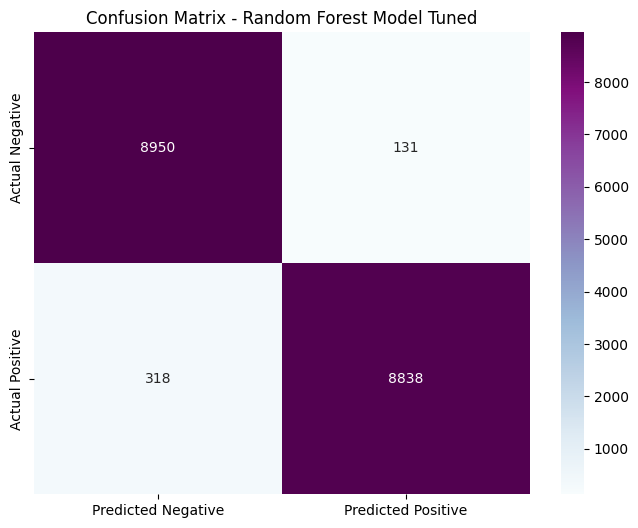

In [81]:
# Make predictions with our new tuned RF model.
y_pred_tunedRF = Best_RandomForest_model.predict(X_test)

# Accuracy
print("Accuracy: ", accuracy_score(y_test, y_pred_tunedRF))

# Detailed classification report
print(classification_report(y_test, y_pred_tunedRF))

# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_tunedRF)
sns.heatmap(cm, annot=True, fmt="d", cmap="BuPu", 
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.title("Confusion Matrix - Random Forest Model Tuned")
plt.show()

### 6.5 Test feature importances of Random Forest Model


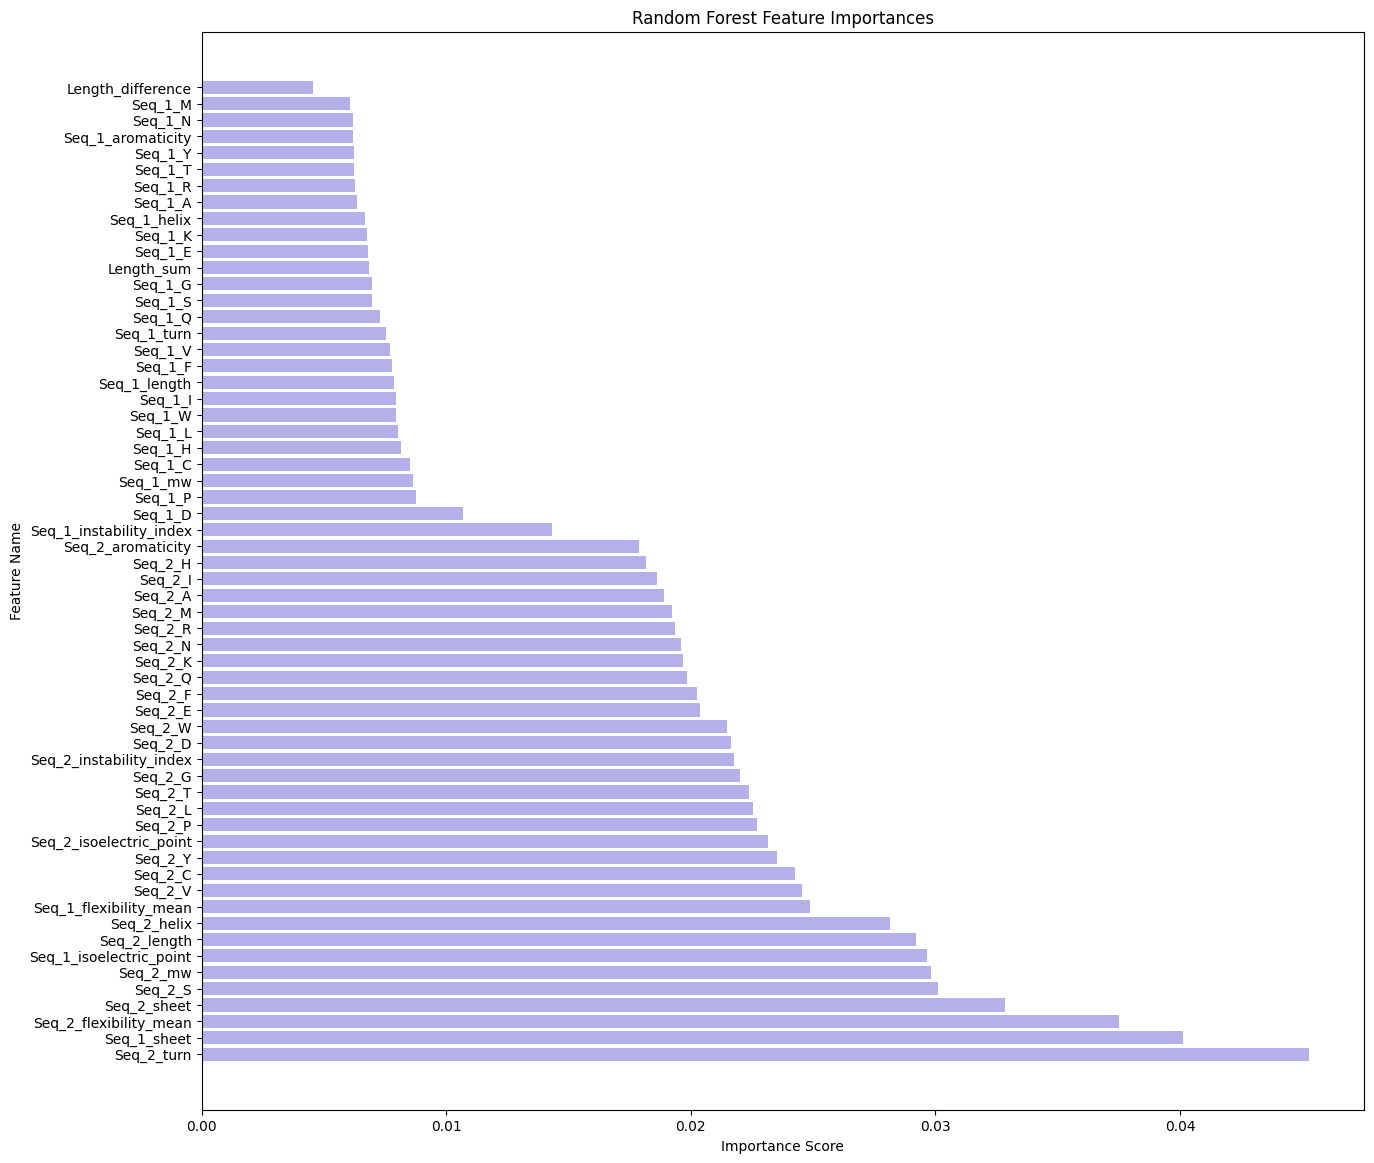

Top feature importances: Seq_2_turn                 0.045262
Seq_1_sheet                0.040122
Seq_2_flexibility_mean     0.037491
Seq_2_sheet                0.032841
Seq_2_S                    0.030110
Seq_2_mw                   0.029806
Seq_1_isoelectric_point    0.029662
Seq_2_length               0.029214
Seq_2_helix                0.028135
Seq_1_flexibility_mean     0.024860
Seq_2_V                    0.024532
Seq_2_C                    0.024249
Seq_2_Y                    0.023539
Seq_2_isoelectric_point    0.023155
Seq_2_P                    0.022712
Seq_2_L                    0.022552
Seq_2_T                    0.022383
Seq_2_G                    0.021998
Seq_2_instability_index    0.021764
Seq_2_D                    0.021635
Seq_2_W                    0.021482
Seq_2_E                    0.020386
Seq_2_F                    0.020236
Seq_2_Q                    0.019867
Seq_2_K                    0.019702
Seq_2_N                    0.019582
Seq_2_R                    0.019348
Seq

In [55]:
# Test feature importances with added names.
importances = Best_RandomForest_model.feature_importances_
importances_df = pd.Series(importances, index=X.columns) # Add the index to have the name of the importance.
sorted_importances = importances_df.sort_values(ascending=False) # Sort features.

#Plot all importances sorted
plt.figure(figsize=(15, 14))
plt.barh(sorted_importances.index, sorted_importances.values, color="#B4B1EA") # Horizonal bar plot for readability.
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.title("Random Forest Feature Importances")
plt.show()
print("Top feature importances:", sorted_importances)

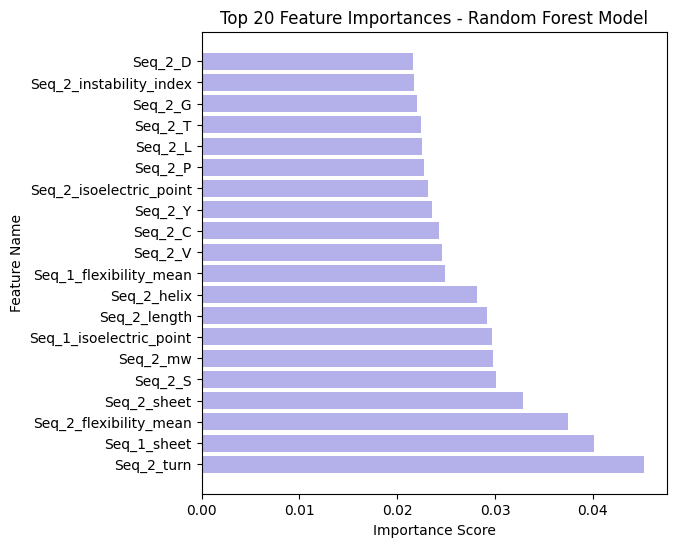

Top 20 feature importances: Seq_2_turn                 0.045262
Seq_1_sheet                0.040122
Seq_2_flexibility_mean     0.037491
Seq_2_sheet                0.032841
Seq_2_S                    0.030110
Seq_2_mw                   0.029806
Seq_1_isoelectric_point    0.029662
Seq_2_length               0.029214
Seq_2_helix                0.028135
Seq_1_flexibility_mean     0.024860
Seq_2_V                    0.024532
Seq_2_C                    0.024249
Seq_2_Y                    0.023539
Seq_2_isoelectric_point    0.023155
Seq_2_P                    0.022712
Seq_2_L                    0.022552
Seq_2_T                    0.022383
Seq_2_G                    0.021998
Seq_2_instability_index    0.021764
Seq_2_D                    0.021635
dtype: float64


In [82]:
# Test feature importances for the top 20 features only.
importances = Best_RandomForest_model.feature_importances_
importances_df = pd.Series(importances, index=X.columns)
top_20importances = importances_df.sort_values(ascending=False).head(20) # Sort for top 20 features.

# Plot top 20 importances.
plt.figure(figsize=(6, 6))
plt.barh(top_20importances.index, top_20importances.values, color="#B4B1EA")
plt.xticks()  # rotate x labels for readability
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.title("Top 20 Feature Importances - Random Forest Model")
plt.show()
print("Top 20 feature importances:", top_20importances)

Features such as sheets and flexibilty are imporant biological factors that can determine protein-protein interaction. 

### 6.6 Permutation Importance - Random Forest Model


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    0.2s finished


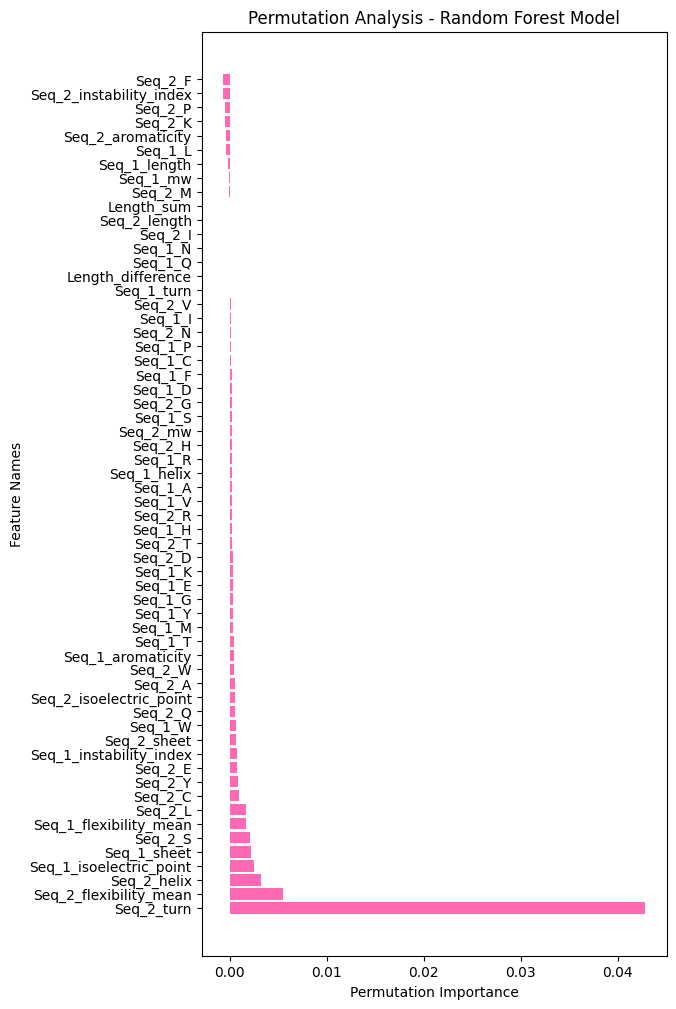

In [65]:
# Get permutation importance.
result = permutation_importance(Best_RandomForest_model, X_test, y_test, n_repeats=5, random_state=1, n_jobs=-1,scoring="accuracy") 
importancesPermutation = result.importances_mean # Take the mean of the importance scores over the number of repeats.

importancesPermutation_df = pd.Series(importancesPermutation, index=X.columns) # Take the index from X columns to get the names.
importancesPermutation_sort = importancesPermutation_df.sort_values(ascending=False) # Sort in order.

# Plot importances.
plt.figure(figsize=(6, 12))
plt.barh(importancesPermutation_sort.index, importancesPermutation_sort, color="hotpink")
plt.xlabel("Permutation Importance")
plt.ylabel("Feature Names")
plt.title("Permutation Analysis - Random Forest Model" )
plt.show()

###  6.7 ROC curve - Random Forest Model

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    0.1s


AUC: 0.9957


[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    0.2s finished
c:\Users\ys641\data_science3\.venv\Lib\site-packages\sklearn\utils\_plotting.py:385: FutureWarning: `estimator_name` is deprecated in 1.7 and will be removed in 1.9. Use `name` instead.
  warnings.warn(


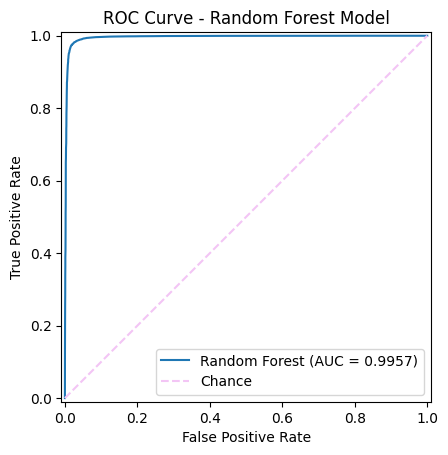

In [62]:
# Making an ROC curve for the Random Forest model.
y_prob_rf = Best_RandomForest_model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class (1) using Predict_proba which gives probabilities for both classes, [:, 1] is class 1, so this selects the probabilities for class 1.
false_positive_rf, true_positive_rf, _ = roc_curve(y_test, y_prob_rf) # Get the false positive and true positive rates for different threshold values.
roc_auc_rf = auc(false_positive_rf, true_positive_rf) # Calculate the AUC for the ROC curve.

RocCurveDisplay(fpr=false_positive_rf, 
                tpr=true_positive_rf, 
                estimator_name=f"Random Forest (AUC = {roc_auc_rf:.4f})" # This displays the AUC value to 4 decimal places instead of rounding to 1.00.
).plot() # Plot the ROC curve using RocCurveDisplay.

plt.title("ROC Curve - Random Forest Model") # Add title to the plot.
plt.plot([0, 1], [0, 1], linestyle="--", color="#F3C5F5", label="Chance") # Add chance line.
plt.legend()

print(f"AUC: {roc_auc_rf:.4f}") # Print the AUC value to 4 decimal places.

////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# 7. Machine Learning Model 2 - XGBoost Model

////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

### 7.1 Base XGBoost model

In [66]:
# Creating the initial base XGBoost model.
XGBoostModel = xgb.XGBClassifier(random_state=42,  n_jobs=-1)

#Fitting the XGBoost model.
XGBoostModel.fit(X_train, y_train)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [67]:
# Making predictions with XGBoost model.
y_pred_xgb = XGBoostModel.predict(X_test)

### 7.1 Test performance of base XGBoost model

Accuracy XGBoost:  0.9796567417886713
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      9081
           1       0.99      0.97      0.98      9156

    accuracy                           0.98     18237
   macro avg       0.98      0.98      0.98     18237
weighted avg       0.98      0.98      0.98     18237



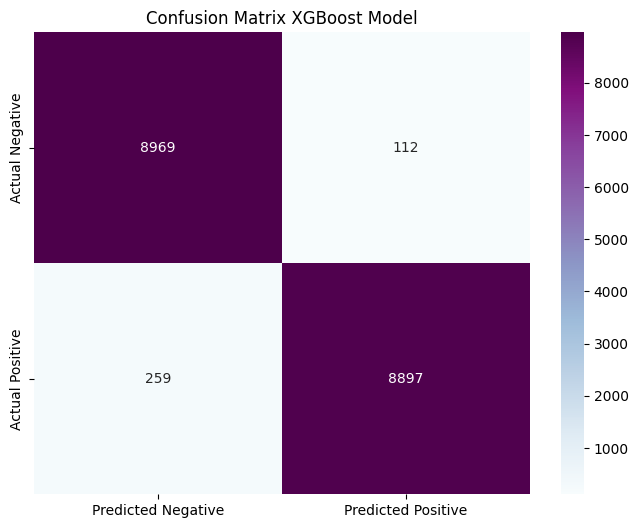

In [68]:
# Accuracy
print("Accuracy XGBoost: ", accuracy_score(y_test, y_pred_xgb))

# Detailed classification report
print(classification_report(y_test, y_pred_xgb))

# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt="d", cmap="BuPu", 
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.title("Confusion Matrix XGBoost Model")
plt.show()

The XGBoost is marginally better than the random forest on basic parameters.


### 7.2 Hyperparameter tuning - XGBoost Model

In [ ]:
# Hyperparameter tuning for the XGBoost model.

# Defining the output from the parameter tuning.
cross_val_score_param = StratifiedKFold(n_splits=5, shuffle = True, random_state=1) # Specifying the 5 fold stratified cross validation from sklearn.mode_selection that I want to use for the parameter tuning.

# XGBoost model - define parameter grid for tuning.
XGBoost_base = XGBClassifier(random_state=42, n_jobs=-1)
Parameter_grid =  {
    "n_estimators":[200, 600, 800],
    "learning_rate": [0.1, 0.05, 0.02],
    "max_depth": [3, 6, 10],
    "subsample": [0.4, 0.8],
    "colsample_bytree": [0.5, 0.8]
}

# Using HalvingGrindSearchCV to speed up parameter tuning time.
XGBoost_grid = HalvingGridSearchCV(
    estimator=XGBoost_base,
    param_grid=Parameter_grid,
    scoring="accuracy",
    refit="accuracy",
    cv=cross_val_score_param,
    n_jobs=-1,
    verbose=3
)

XGBoost_grid.fit(X_train, y_train) # This will train and fit the data to the models in the grid.
Best_XGBoostModel = XGBoost_grid.best_estimator_ # Best_XGBoostModel will be the best of the tuned RF models from the grid.

print("Best parameters:", XGBoost_grid.best_params_)
print("Best cross validation accuracy:", XGBoost_grid.best_score_)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 675
max_resources_: 54708
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 108
n_resources: 675
Fitting 5 folds for each of 108 candidates, totalling 540 fits
----------
iter: 1
n_candidates: 36
n_resources: 2025
Fitting 5 folds for each of 36 candidates, totalling 180 fits
----------
iter: 2
n_candidates: 12
n_resources: 6075
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 3
n_candidates: 4
n_resources: 18225
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 4
n_candidates: 2
n_resources: 54675
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 800, 'subsample': 0.8}
Best cross validation accuracy: 0.9852578262107039


### 7.3 Optimised hyperparameters - Tuned XGBoost Model 

To save running each restart, load best known model.

In [69]:
Best_XGBoostModel = XGBClassifier(n_estimators = 800, learning_rate = 0.05, max_depth = 10, subsample = 0.8, colsample_bytree = 0.8, n_jobs = -1, random_state = 42)
Best_XGBoostModel.fit(X_train,y_train)
Best_XGBoostModel

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

In [70]:
#Fitting the best tuned XGBoost model.
Best_XGBoostModel.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

### 7.4 Assess XGBoost tuned model accuracy

In [71]:
# Making predictions with tuned XGBoost model.
y_pred_xgb_best = Best_XGBoostModel.predict(X_test)

Accuracy XGBoost Tuned:  0.9860174370784669
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      9081
           1       0.99      0.98      0.99      9156

    accuracy                           0.99     18237
   macro avg       0.99      0.99      0.99     18237
weighted avg       0.99      0.99      0.99     18237



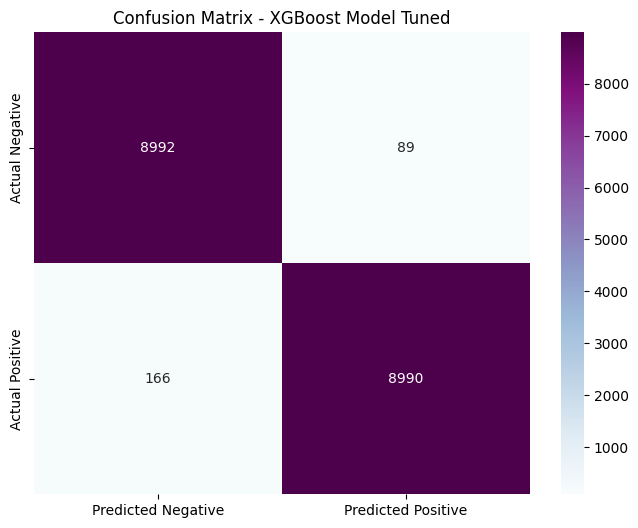

In [72]:
# Accuracy
print("Accuracy XGBoost Tuned: ", accuracy_score(y_test, y_pred_xgb_best))

# Detailed classification report
print(classification_report(y_test, y_pred_xgb_best))

# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_xgb_best)
sns.heatmap(cm, annot=True, fmt="d", cmap="BuPu", 
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.title("Confusion Matrix - XGBoost Model Tuned")
plt.show()

Extract detailed CV scores for tuned XGBoost model.

In [ ]:
# Extract score results from cross validation for best model.
best_XGBoostModel_df = pd.DataFrame(XGBoost_grid.cv_results_) # Using the grid, output every test and train score for each fold using every parameter combination. 
best_cv_scores_index = XGBoost_grid.best_index_ # Find the index of the best model (best parameters).

#Getting the mean and std of the cv scores for the best model.
mean_score_best_XGB_model = XGBoost_grid.cv_results_["mean_test_score"][best_cv_scores_index] # Find the mean test score of every fold for the best model.
std_score_best_XGB_model  = XGBoost_grid.cv_results_["std_test_score"][best_cv_scores_index] # Finding the std of the test scores for every fold of the best model.

# Find the cv score for each of the 5 folds for the best model.
fold_columns = [f"split{i}_test_score" for i in range(5)] # Get the column name of each fold test score. (5 folds range).
per_fold_best = best_XGBoostModel_df.loc[best_cv_scores_index, fold_columns] # Find the value of the best model CV for each column header (fold).

# Print the results.
print(f"Cross validation scores - tuned Random Forest Model: \n{per_fold_best}")
print(f"Best CV accuracy mean - tuned Random Forest Model: {mean_score_best_XGB_model:.4f} ± {std_score_best_XGB_model:.4f}")

Cross validation scores - tuned Random Forest Model: 
split0_test_score    0.986008
split1_test_score    0.983996
split2_test_score    0.984636
split3_test_score    0.987287
split4_test_score    0.984361
Name: 161, dtype: object
Best CV accuracy mean - tuned Random Forest Model: 0.9853 ± 0.0012


### 7.5 Feature importances - XGBoost Model


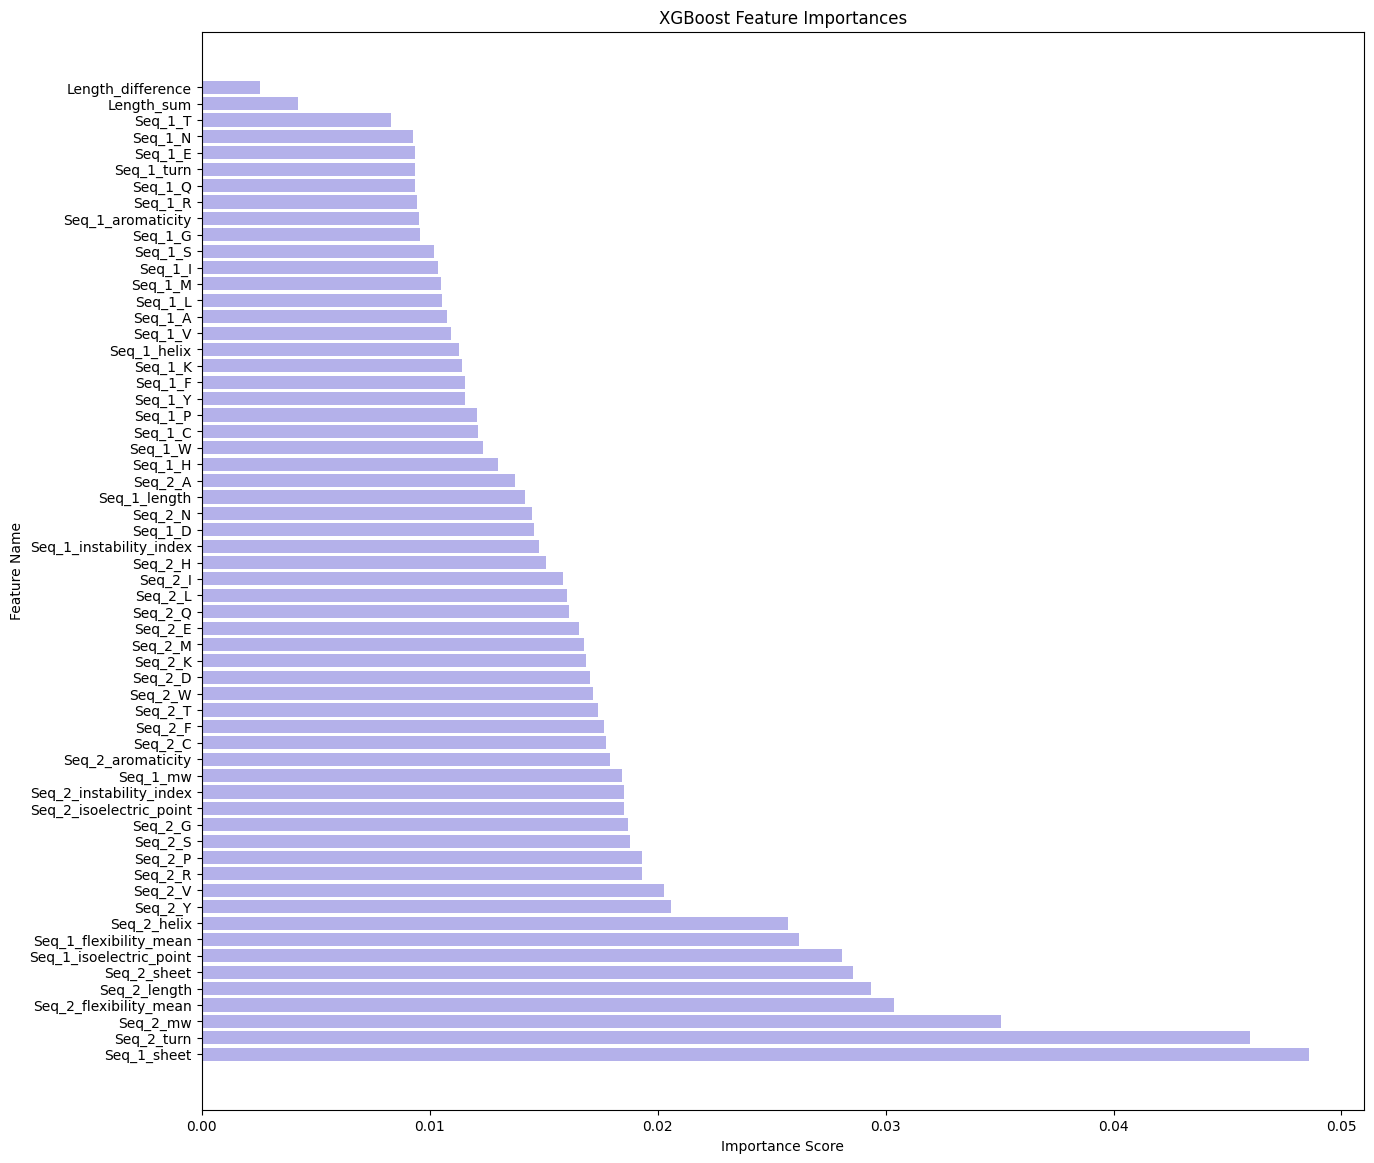

Top feature importances: Seq_1_sheet                0.048560
Seq_2_turn                 0.045970
Seq_2_mw                   0.035049
Seq_2_flexibility_mean     0.030377
Seq_2_length               0.029348
Seq_2_sheet                0.028595
Seq_1_isoelectric_point    0.028107
Seq_1_flexibility_mean     0.026187
Seq_2_helix                0.025710
Seq_2_Y                    0.020593
Seq_2_V                    0.020298
Seq_2_R                    0.019335
Seq_2_P                    0.019324
Seq_2_S                    0.018795
Seq_2_G                    0.018706
Seq_2_isoelectric_point    0.018534
Seq_2_instability_index    0.018515
Seq_1_mw                   0.018429
Seq_2_aromaticity          0.017896
Seq_2_C                    0.017760
Seq_2_F                    0.017652
Seq_2_T                    0.017380
Seq_2_W                    0.017153
Seq_2_D                    0.017053
Seq_2_K                    0.016882
Seq_2_M                    0.016795
Seq_2_E                    0.016548
Seq

In [73]:
# Test feature all importances.
importancesXGB = Best_XGBoostModel.feature_importances_
importancesXGB_df = pd.Series(importancesXGB, index=X.columns)
sorted_importancesXGB = importancesXGB_df.sort_values(ascending=False) # Sort features.

# Plot top 20 importances.
plt.figure(figsize=(15, 14))
plt.barh(sorted_importancesXGB.index, sorted_importancesXGB.values, color="#B4B1EA")
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.title("XGBoost Feature Importances")
plt.show()
print("Top feature importances:", sorted_importancesXGB)

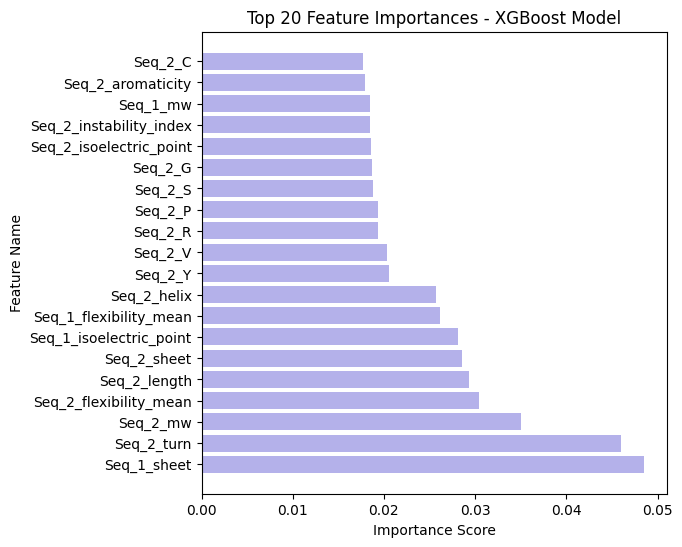

Top 20 feature importances: Seq_1_sheet                0.048560
Seq_2_turn                 0.045970
Seq_2_mw                   0.035049
Seq_2_flexibility_mean     0.030377
Seq_2_length               0.029348
Seq_2_sheet                0.028595
Seq_1_isoelectric_point    0.028107
Seq_1_flexibility_mean     0.026187
Seq_2_helix                0.025710
Seq_2_Y                    0.020593
Seq_2_V                    0.020298
Seq_2_R                    0.019335
Seq_2_P                    0.019324
Seq_2_S                    0.018795
Seq_2_G                    0.018706
Seq_2_isoelectric_point    0.018534
Seq_2_instability_index    0.018515
Seq_1_mw                   0.018429
Seq_2_aromaticity          0.017896
Seq_2_C                    0.017760
dtype: float32


In [83]:
# Test feature importances for the top 20 features only.
importancesXGB = Best_XGBoostModel.feature_importances_
importancesXGB_df = pd.Series(importancesXGB, index=X.columns)
sorted_importancesXGB = importancesXGB_df.sort_values(ascending=False).head(20) # Sort features and only take 20.
 
# Plot top 20 importances.
plt.figure(figsize=(6, 6))
plt.barh(sorted_importancesXGB.index, sorted_importancesXGB.values, color="#B4B1EA")
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.title("Top 20 Feature Importances - XGBoost Model")
plt.show()
print("Top 20 feature importances:", sorted_importancesXGB)

### 7.6 Permutation Importance - XGBoost

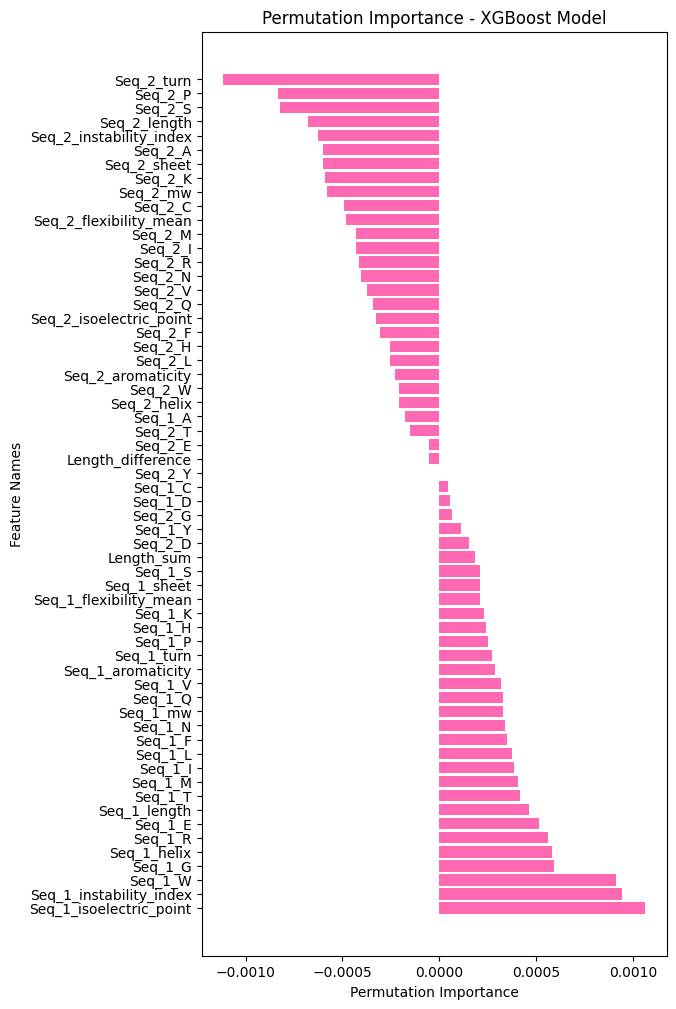

In [85]:
# Get permutation importance for XGBoost Model.
resultXGBoost = permutation_importance(Best_XGBoostModel, X_test, y_test, n_repeats=5, random_state=1, n_jobs=-1, scoring="accuracy") 
importancesPermutationXGBoost = resultXGBoost.importances_mean # take the mean of the importance scores over the number of repeats

importancesPermutationXGBoost_df = pd.Series(importancesPermutationXGBoost, index=X.columns) # take the index from X columns to get the names
importancesPermutationXGBoost_sort = importancesPermutationXGBoost_df.sort_values(ascending=False) # sort in order

# plot importances
plt.figure(figsize=(6, 12))
plt.barh(importancesPermutationXGBoost_sort.index, importancesPermutationXGBoost_sort, color="hotpink")
plt.title("Permutation Importance - XGBoost Model")
plt.xlabel("Permutation Importance")
plt.ylabel("Feature Names")
plt.show()

### 7.7 ROC curve - XGBoost

AUC: 0.9975


c:\Users\ys641\data_science3\.venv\Lib\site-packages\sklearn\utils\_plotting.py:385: FutureWarning: `estimator_name` is deprecated in 1.7 and will be removed in 1.9. Use `name` instead.
  warnings.warn(


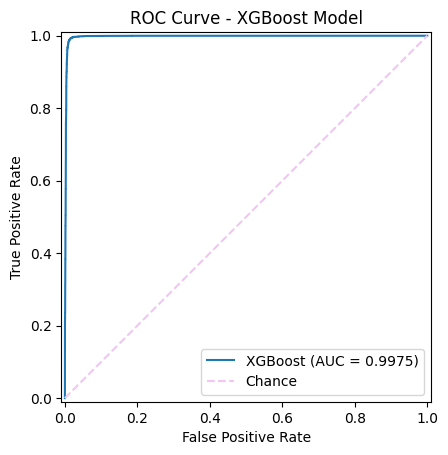

In [88]:
# Making an ROC curve for the XGBoost model.
y_prob_xgb = Best_XGBoostModel.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class (1) using Predict_proba which gives probabilities for both classes, [:, 1] is class 1, so this selects the probabilities for class 1.
false_positive_xgb, true_positive_xgb, _ = roc_curve(y_test, y_prob_xgb) # Get the false positive and true positive rates for different threshold values.
roc_auc_xgb = auc(false_positive_xgb, true_positive_xgb) # Calculate the AUC for the ROC curve.

RocCurveDisplay(fpr=false_positive_xgb, 
                tpr=true_positive_xgb, 
                estimator_name=f"XGBoost (AUC = {roc_auc_xgb:.4f})" # This displays the AUC value to 4 decimal places instead of rounding to 1.00.
).plot() # Plot the ROC curve using RocCurveDisplay.
plt.title("ROC Curve - XGBoost Model") # Add title to the plot.
plt.plot([0, 1], [0, 1], linestyle="--", color="#F3C5F5", label="Chance") #Chance line adding.
plt.legend()

print(f"AUC: {roc_auc_xgb:.4f}") # Print the AUC value to 4 decimal places.


///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
